<a href="https://colab.research.google.com/github/DarshitJain04/PRML-project/blob/main/Pill_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing Libraries and Dependencies

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, recall_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from sklearn.preprocessing import Normalizer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
# data = pd.read_csv('drive/My Drive/preprocessed_data.csv')

Mounted at /content/drive


#Dataset Description

In [3]:
# train = pd.read_csv('drive/My Drive/drugsComTrain_raw.csv')
# test = pd.read_csv('drive/My Drive/drugsComTest_raw.csv')
train = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTrain_raw.csv')
test = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTest_raw.csv')
# getting the shapes
print("Shape of train :", train.shape)
print("Shape of test :", test.shape)

Shape of train : (161297, 7)
Shape of test : (53766, 7)


In [4]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [5]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [6]:
# as both the dataset contains same columns we can combine them for better analysis
data = pd.concat([train, test])

# checking the shape
data.shape

(215063, 7)

# Exploratory Data Analysis

In [8]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [ ]:
# textString=listToString(data["condition"])
# wordcloud = WordCloud(max_words = 100, width = 1500, height = 1000, random_state=1, background_color='navy', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(textString)

# plt.title('Most Common Conditions among the Patients', fontsize = 30)
# print(wordcloud)
# plt.axis('off')
# plt.imshow(wordcloud)
# plt.show()

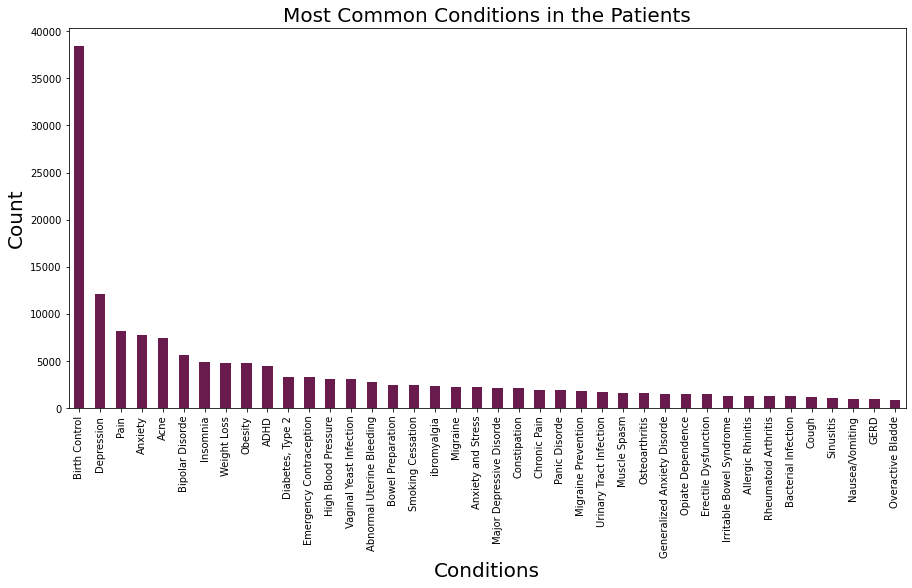

In [20]:
# checking the different types of conditions patients

data['condition'].value_counts().head(40).plot.bar(figsize = (15, 7), color = '#6A1B4D')
plt.title('Most Common Conditions in the Patients', fontsize = 20)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.show()

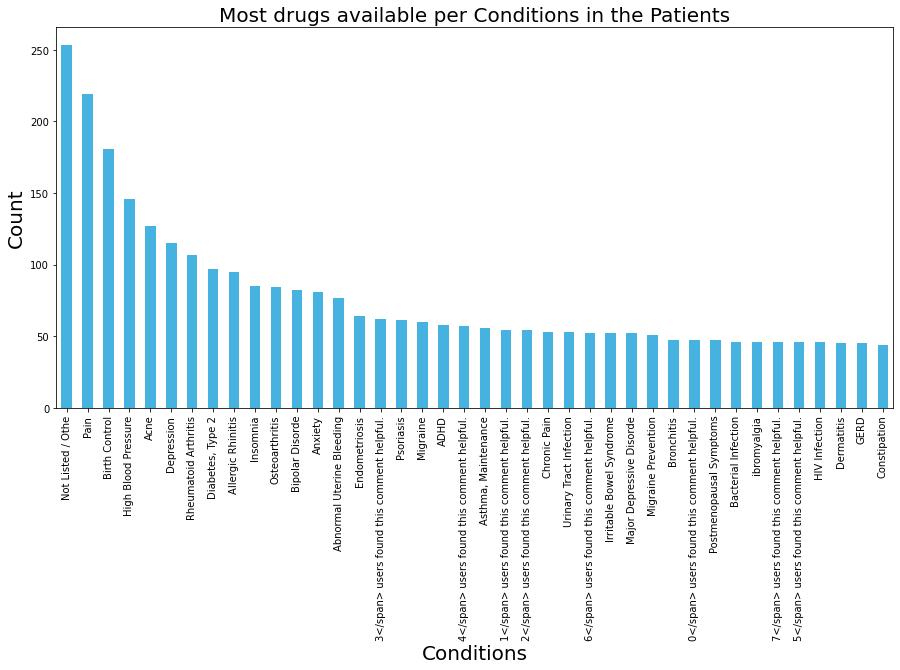

In [17]:
data.groupby(['condition'])['drugName'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (15, 7), color = '#46B2E0')
plt.title('Most drugs available per Conditions in the Patients', fontsize = 20)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.show()

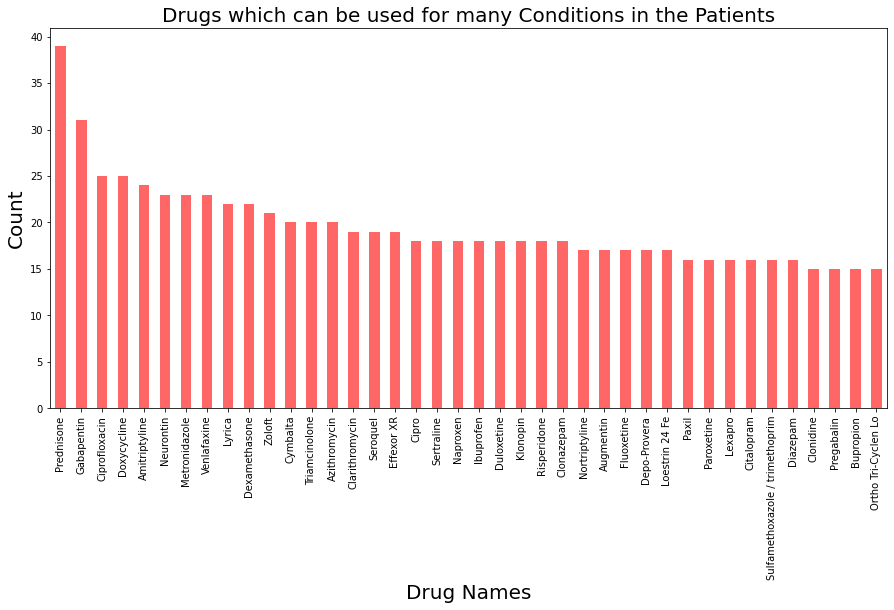

In [18]:
# checking the most popular drugs per conditions

data.groupby(['drugName'])['condition'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (15, 7), color = '#FF6666')
plt.title('Drugs which can be used for many Conditions in the Patients', fontsize = 20)
plt.xlabel('Drug Names', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.show()

In [ ]:
data['rating'].value_counts()

10    68005
9     36708
1     28918
8     25046
7     12547
5     10723
2      9265
3      8718
6      8462
4      6671
Name: rating, dtype: int64

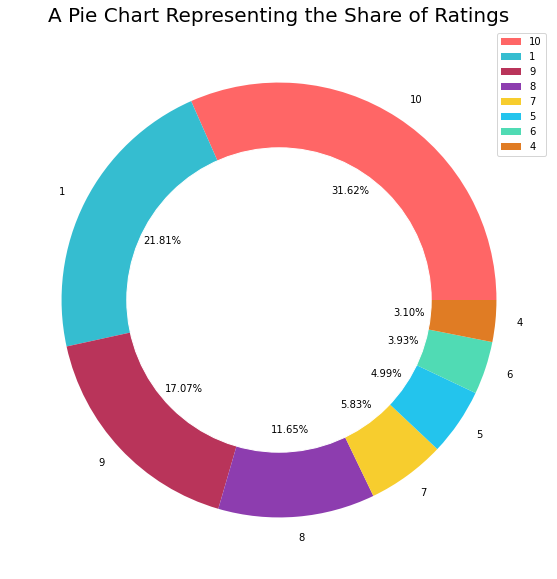

In [23]:
size = [68005, 46901, 36708, 25046, 12547, 10723, 8462, 6671]
colors = ['#FF6666', '#35BDD0', '#B9345A',  '#8D3DAF', '#F7CD2E', '#23C4ED', '#50DBB4', '#E07C24']
labels = "10", "1", "9", "8", "7", "5", "6", "4"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Share of Ratings', fontsize = 20)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

([<matplotlib.axis.XTick at 0x7ff0dc8fe990>,
 <a list of 10 Text major ticklabel objects>)

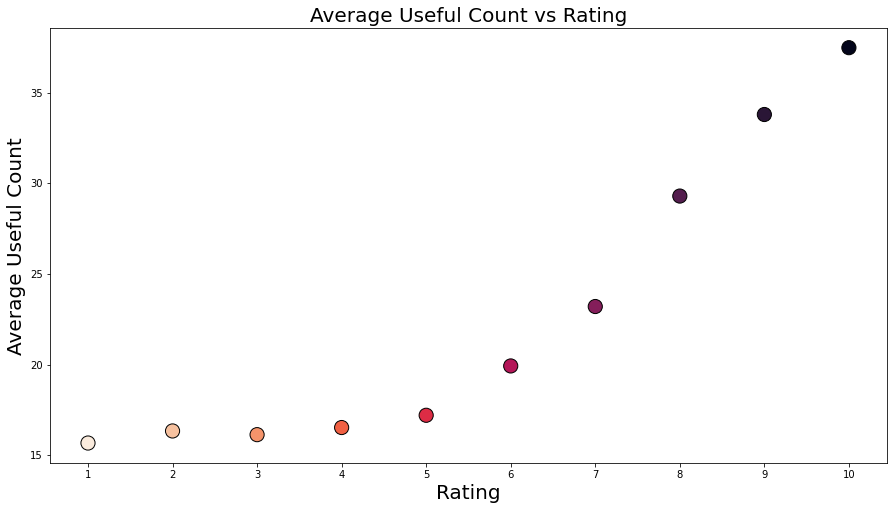

In [45]:
temp = []
for i in range(1, 11):
    temp.append([i, np.sum(data[data.rating == i].usefulCount) / np.sum([data.rating == i])]) 
temp = np.asarray(temp)

plt.scatter(temp[:, 0], temp[:, 1], c=temp[:, 0], cmap='rocket_r', s=200, edgecolors='k')
plt.title('Average Useful Count vs Rating', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)
plt.ylabel('Average Useful Count', fontsize = 20)
plt.xticks([i for i in range(1, 11)])

Add review sentiment column which acts as target variable. It gives a (good,bad)-(1,0) value based on rating of the drug

In [24]:
# feature engineering 
# let's make a new column review sentiment 

data.loc[(data['rating'] >= 7), 'Review_Sentiment'] = 2
data.loc[(data['rating']== 5), 'Review_Sentiment'] = 1
data.loc[(data['rating']== 6), 'Review_Sentiment'] = 1
data.loc[(data['rating']<5), 'Review_Sentiment'] = 0
data['Review_Sentiment'].value_counts()

2.0    142306
0.0     53572
1.0     19185
Name: Review_Sentiment, dtype: int64

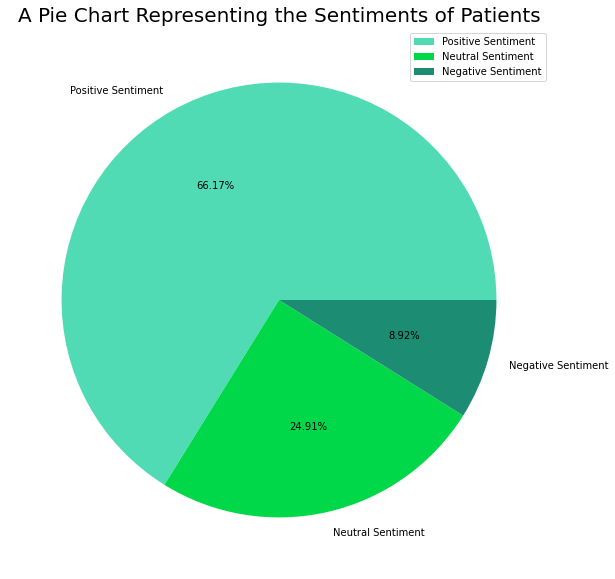

In [25]:
size = [142306,53572,19185]
colors = ['#50DBB4', '#00D84A','#1C8D73']
labels = "Positive Sentiment","Neutral Sentiment","Negative Sentiment"
plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels,  autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Sentiments of Patients', fontsize = 20)
plt.legend()
plt.show()

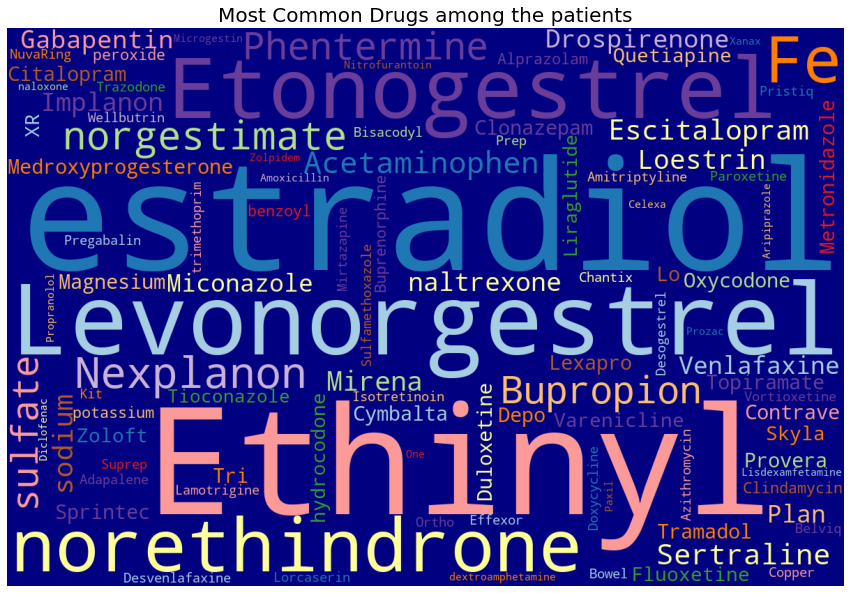

In [13]:
stopwords = set(STOPWORDS)
textString=listToString(data["drugName"])
wordcloud = WordCloud(max_words = 100, width = 1200, height = 800, random_state=1, background_color='navy', colormap='Paired', collocations=False, stopwords = STOPWORDS).generate(textString)
plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Drugs among the patients', fontsize = 20)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

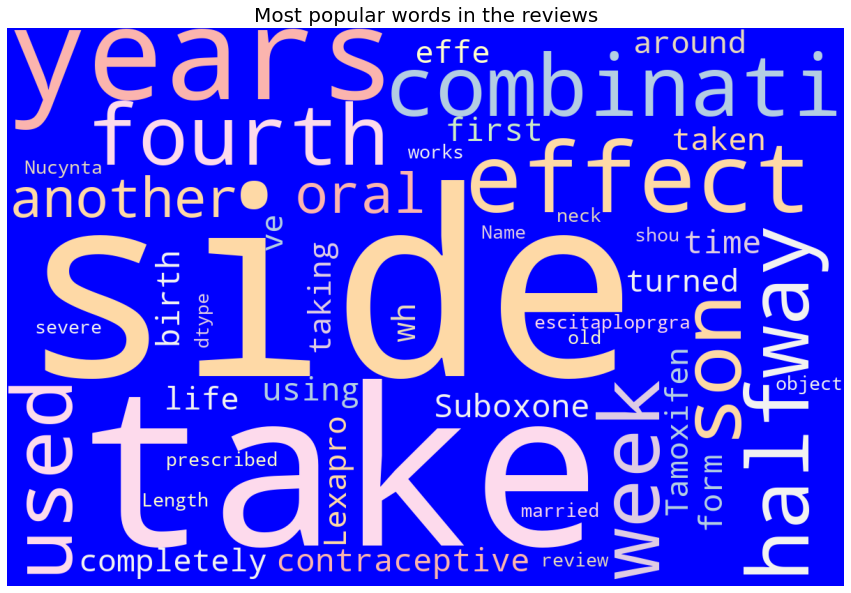

In [22]:
wordcloud = WordCloud(background_color='blue', colormap='Pastel1', stopwords = stopwords, width = 1200, height = 800).generate(str(data['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most popular words in the reviews', fontsize = 20)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

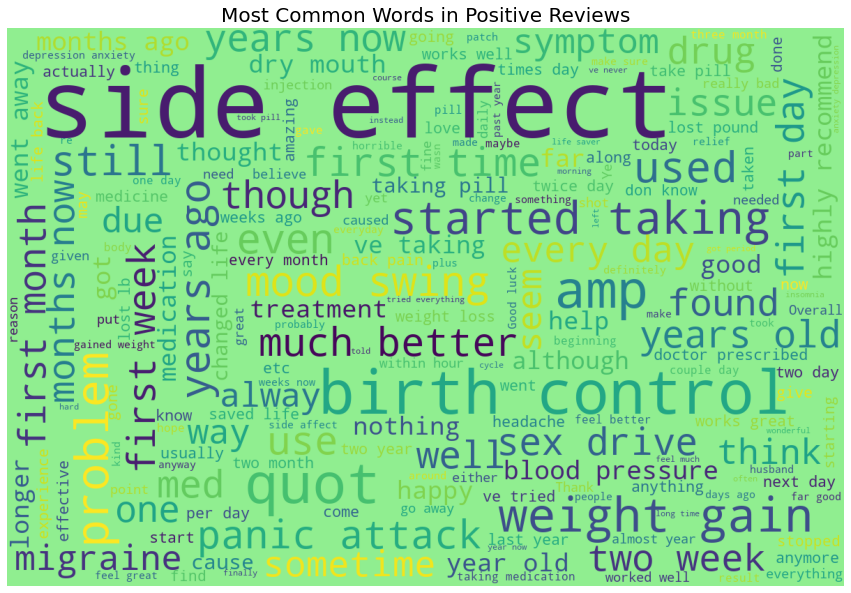

In [26]:
# making Words cloud for the postive sentiments

positive_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 2]])
wordcloud = WordCloud(background_color = 'lightgreen', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)
plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words in Positive Reviews', fontsize = 20)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

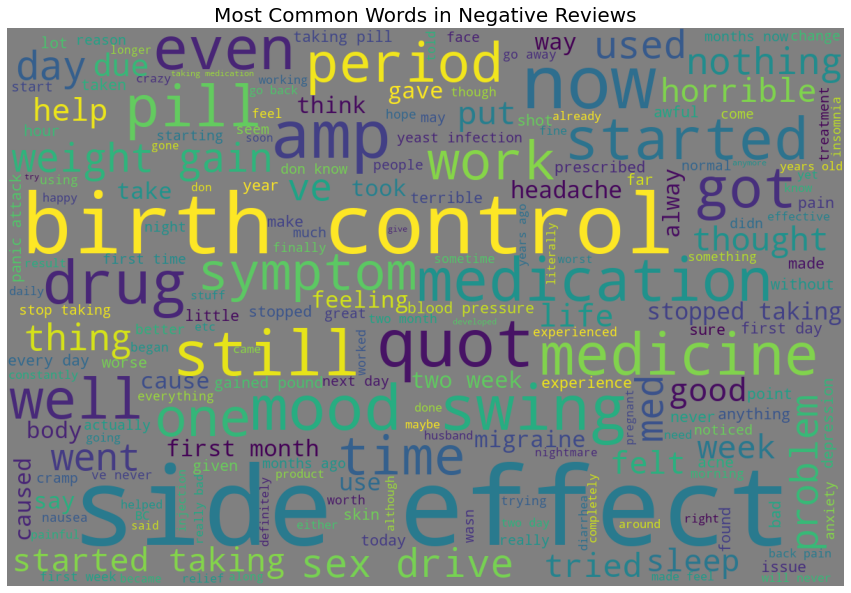

In [27]:
negative_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 0]])
wordcloud = WordCloud(background_color = 'grey', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)
plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words in Negative Reviews', fontsize = 20)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

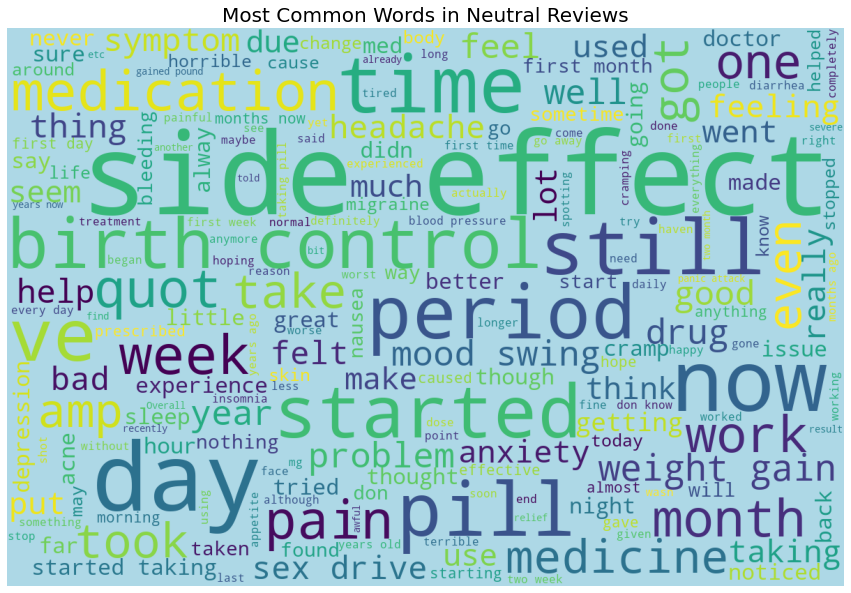

In [28]:
neutral_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 1]])
wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(neutral_sentiments)
plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words in Neutral Reviews', fontsize = 20)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Extracting year,month and day from the date column

In [29]:
# converting the date into datetime format
data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

# now extracting year from date
data['Year'] = data['date'].dt.year

# extracting the month from the date
data['month'] = data['date'].dt.month

# extracting the days from the date
data['day'] = data['date'].dt.day

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


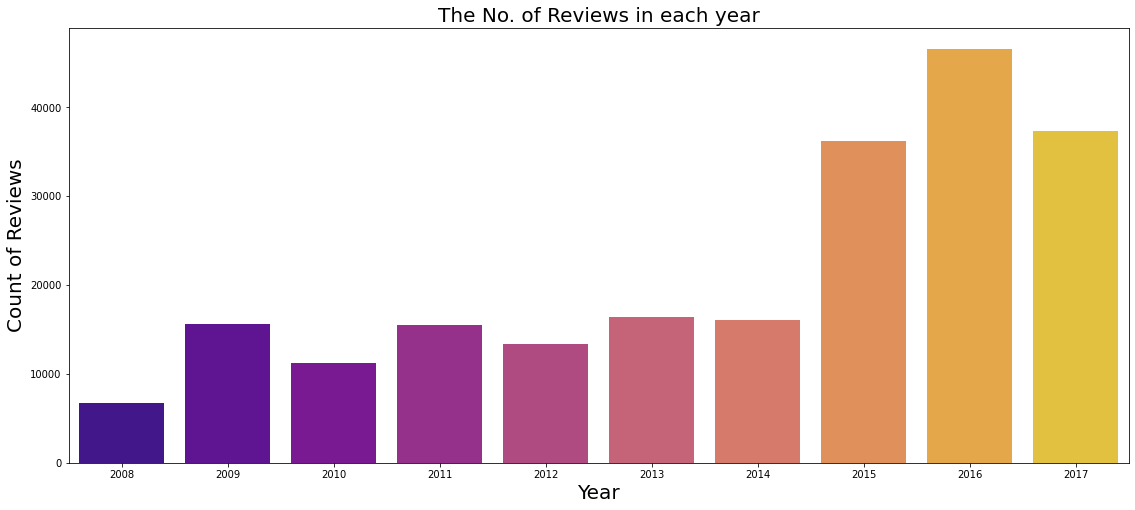

In [30]:
# looking at the no. of reviews in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(data['Year'], palette ='plasma')
plt.title('The No. of Reviews in each year', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Count of Reviews', fontsize = 20)
plt.show()

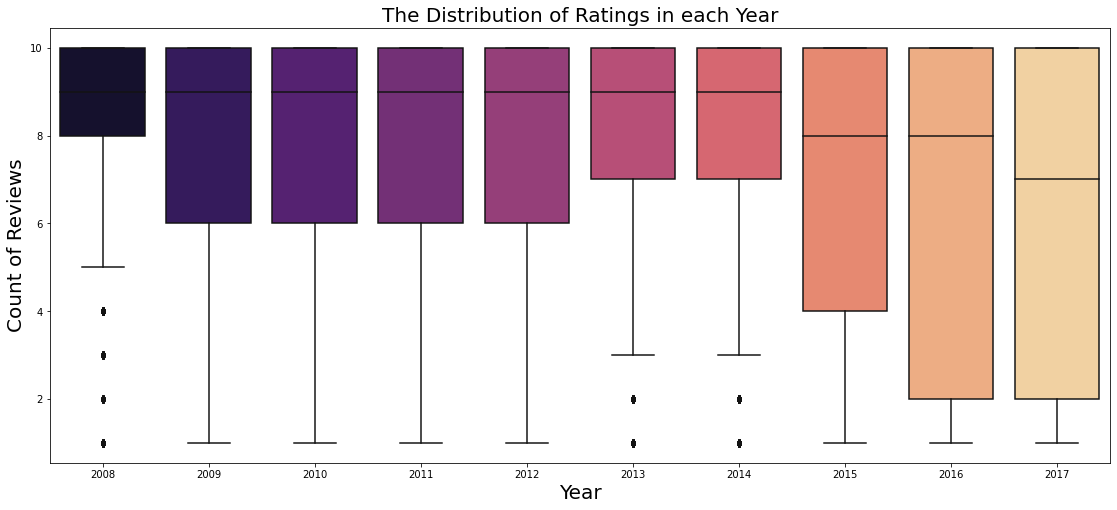

In [31]:
# looking at the no. of ratings in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.boxplot(x = data['Year'], y = data['rating'], palette ='magma')
plt.title('The Distribution of Ratings in each Year', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Count of Reviews', fontsize = 20)
plt.show()

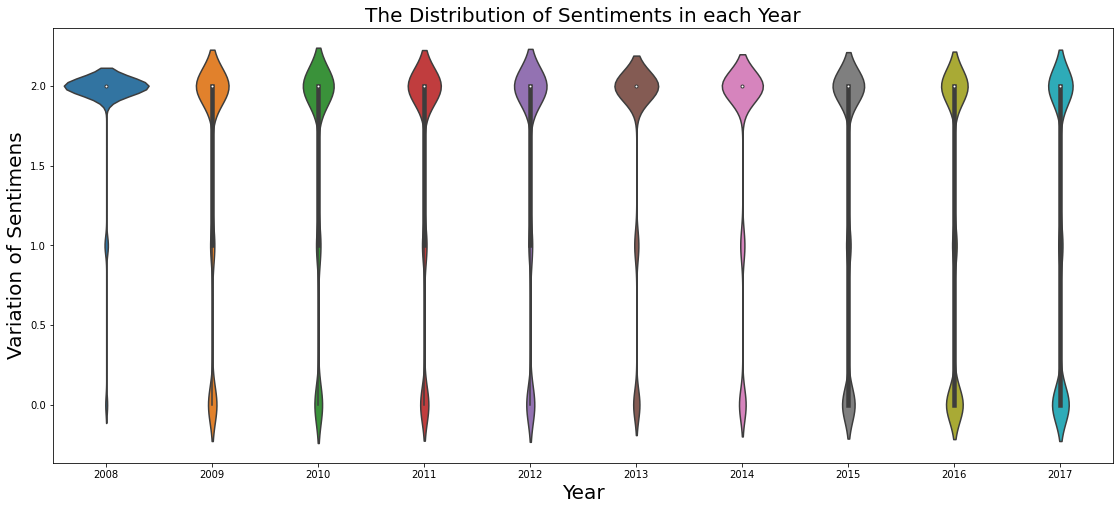

In [33]:
# looking at the no. of ratings in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.violinplot(x = data['Year'], y = data['Review_Sentiment'])
plt.title('The Distribution of Sentiments in each Year', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Variation of Sentimens', fontsize = 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


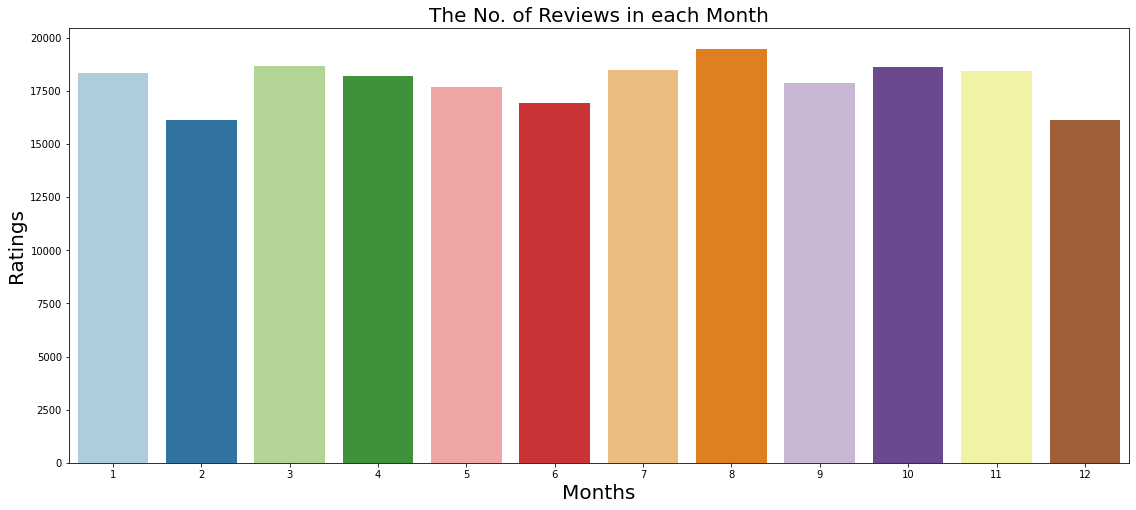

In [35]:
# looking at the no. of reviews in each of the months

plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(data['month'], palette = 'Paired')
plt.title('The No. of Reviews in each Month', fontsize = 20)
plt.xlabel('Months', fontsize = 20)
plt.ylabel('Ratings', fontsize = 20)
plt.show()

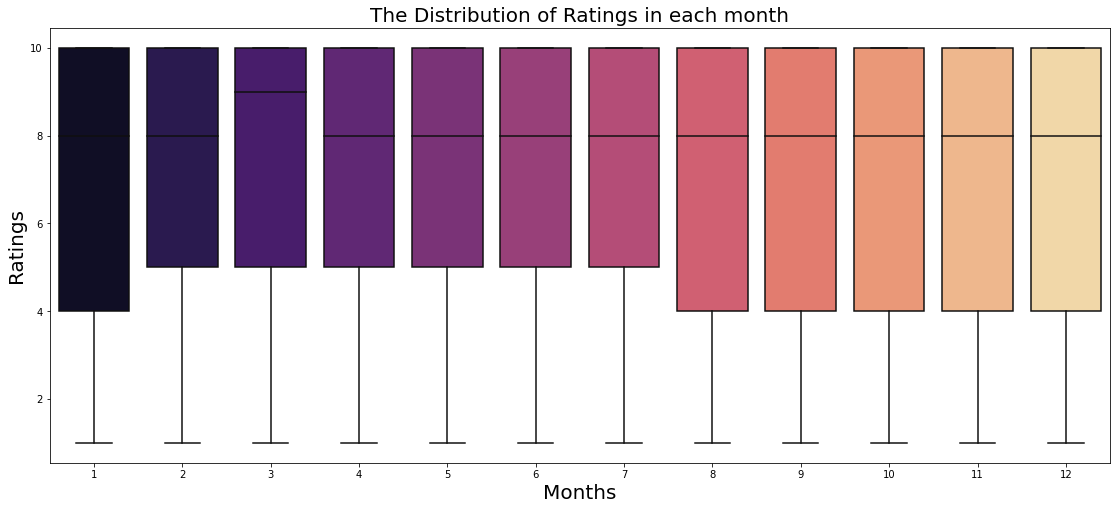

In [36]:
# looking at the no. of ratings in each of the month

plt.rcParams['figure.figsize'] = (19, 8)
sns.boxplot(x = data['month'], y = data['rating'], palette ='magma')
plt.title('The Distribution of Ratings in each month', fontsize = 20)
plt.xlabel('Months', fontsize = 20)
plt.ylabel('Ratings', fontsize = 20)
plt.show()

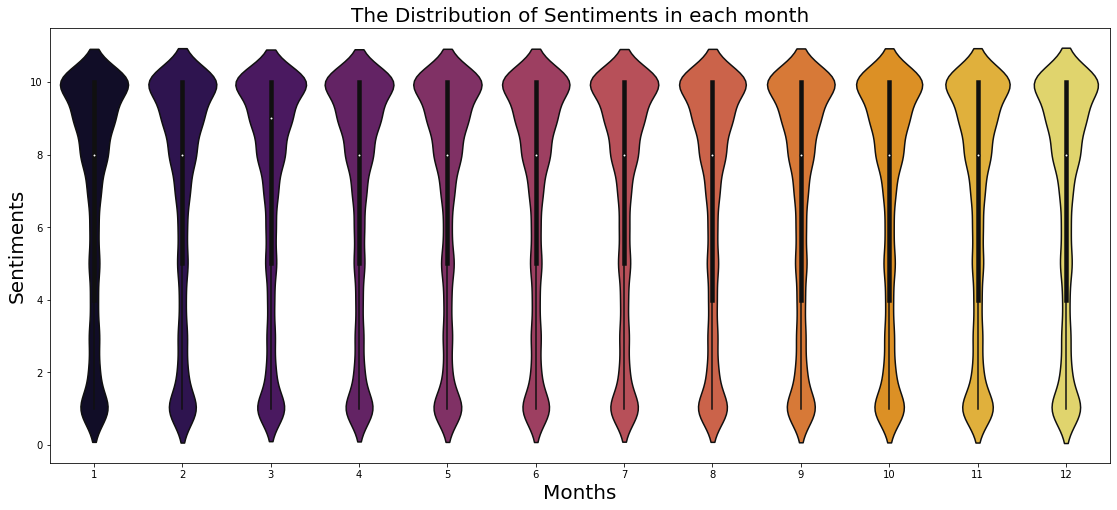

In [37]:
# looking at the no. of ratings in each of the month

plt.rcParams['figure.figsize'] = (19, 8)
sns.violinplot(x = data['month'], y = data['rating'], palette ='inferno')
plt.title('The Distribution of Sentiments in each month', fontsize = 20)
plt.xlabel('Months', fontsize = 20)
plt.ylabel('Sentiments', fontsize = 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


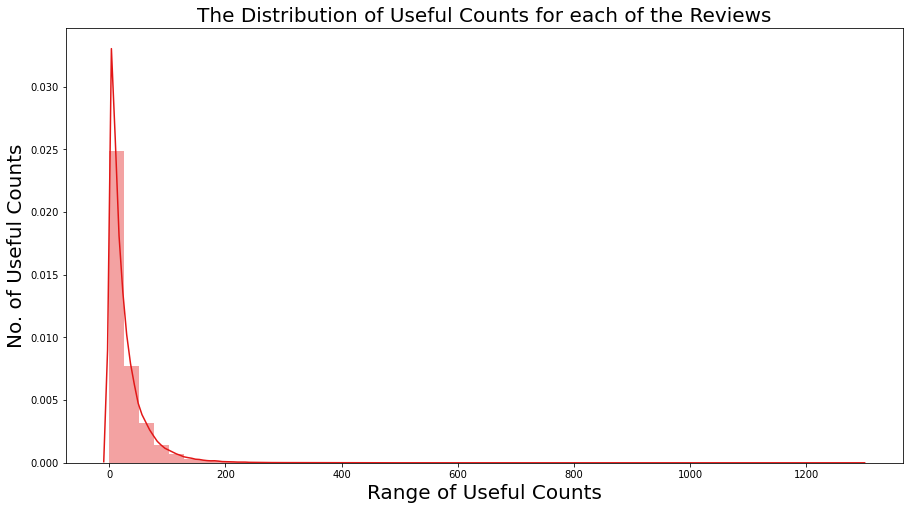

In [38]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.distplot(data['usefulCount'], color = '#E21717')
plt.title('The Distribution of Useful Counts for each of the Reviews', fontsize = 20)
plt.xlabel('Range of Useful Counts', fontsize = 20)
plt.ylabel('No. of Useful Counts', fontsize = 20)
plt.show()

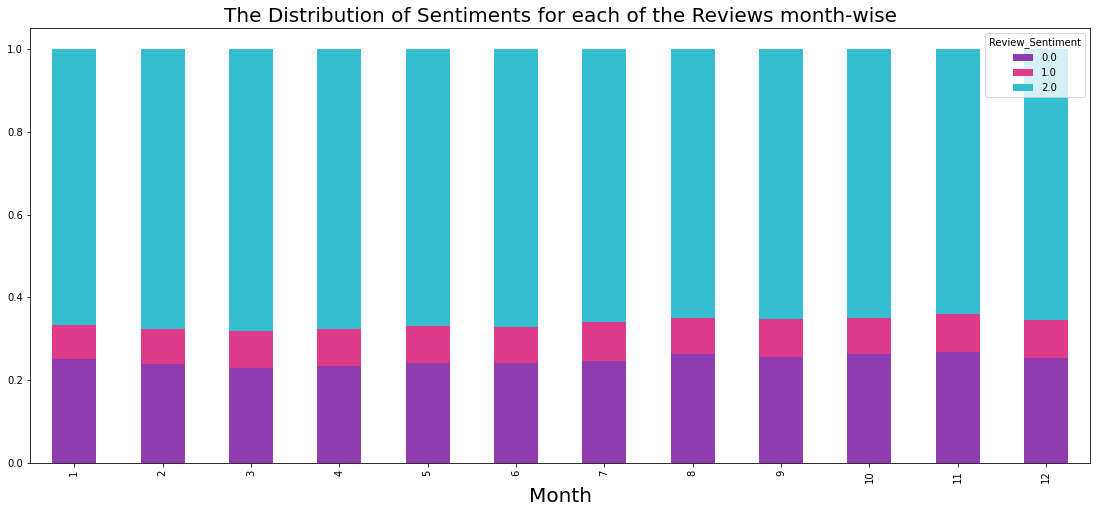

In [39]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['month'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['#8D3DAF', '#E03B8B', '#35BDD0'])
plt.title('The Distribution of Sentiments for each of the Reviews month-wise', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
plt.show()

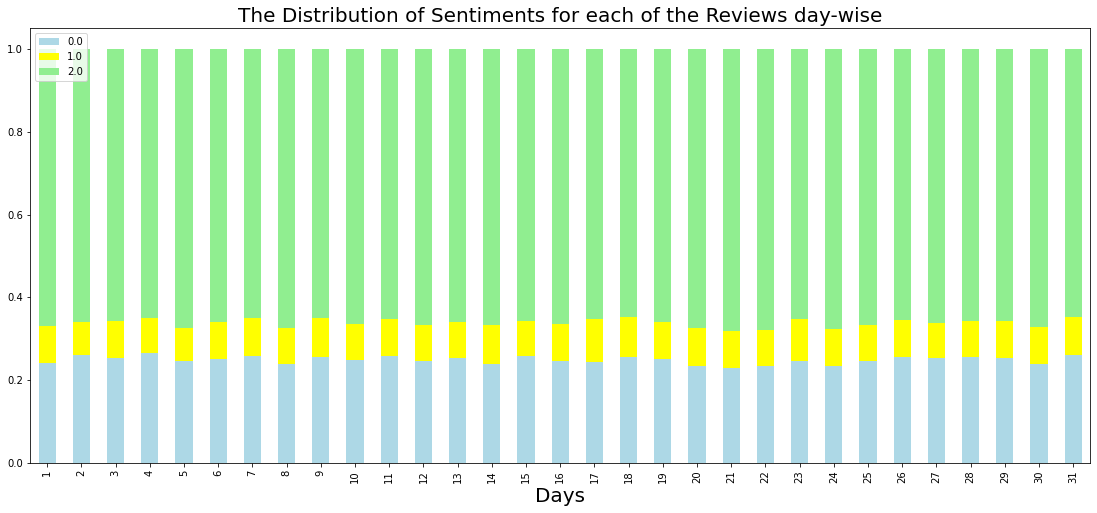

In [40]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['day'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['lightblue', 'yellow', 'lightgreen'])
plt.title('The Distribution of Sentiments for each of the Reviews day-wise', fontsize = 20)
plt.xlabel('Days', fontsize = 20)
plt.legend(loc = 2)
plt.show()

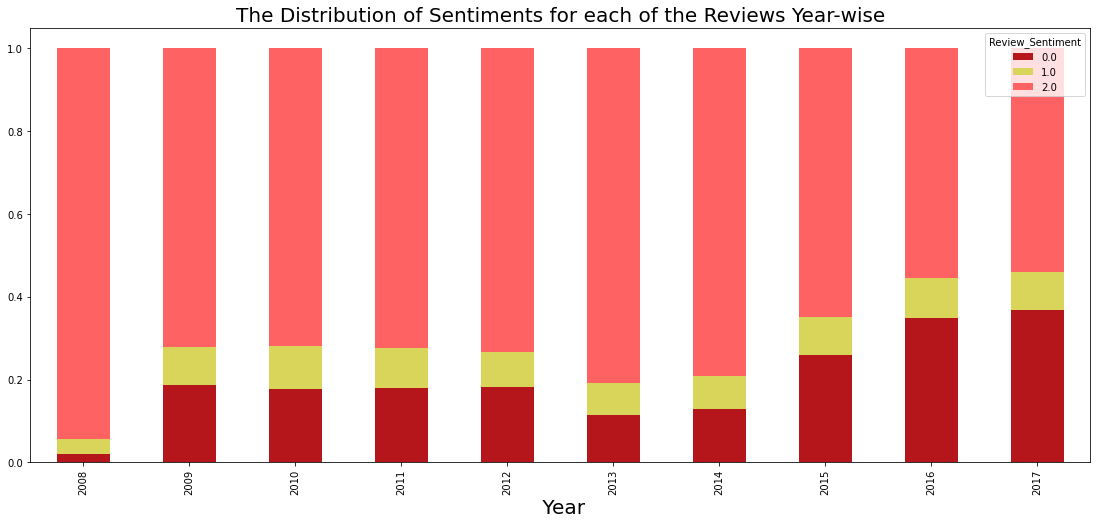

In [42]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['Year'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['#B4161B', '#D9D55B', '#FF6263'])
plt.title('The Distribution of Sentiments for each of the Reviews Year-wise', fontsize = 20)
plt.xlabel(' Year', fontsize = 20)
plt.show()

# Data Preprocessing

##Basic Data Info

In [ ]:
data.describe()

,uniqueID,rating,usefulCount,Review_Sentiment,Year,month,day
count,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004,1.412595,2013.944323,6.503076,15.657282
std,67007.913366,3.275554,36.346069,0.860559,2.711913,3.421765,8.782353
min,0.000000,1.000000,0.000000,0.000000,2008.000000,1.000000,1.000000
25%,58115.500000,5.000000,6.000000,1.000000,2012.000000,4.000000,8.000000
50%,115867.000000,8.000000,16.000000,2.000000,2015.000000,7.000000,16.000000
75%,173963.500000,10.000000,36.000000,2.000000,2016.000000,9.000000,23.000000
max,232291.000000,10.000000,1291.000000,2.000000,2017.000000,12.000000,31.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   uniqueID          215063 non-null  int64         
 1   drugName          215063 non-null  object        
 2   condition         213869 non-null  object        
 3   review            215063 non-null  object        
 4   rating            215063 non-null  int64         
 5   date              215063 non-null  datetime64[ns]
 6   usefulCount       215063 non-null  int64         
 7   Review_Sentiment  215063 non-null  float64       
 8   Year              215063 non-null  int64         
 9   month             215063 non-null  int64         
 10  day               215063 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 24.7+ MB


Check for null values

In [ ]:
data.isnull().any()

uniqueID            False
drugName            False
condition            True
review              False
rating              False
date                False
usefulCount         False
Review_Sentiment    False
Year                False
month               False
day                 False
dtype: bool

In [ ]:
data['condition'].isnull().sum()

1194

In [ ]:
# we will delete the rows so that the data does not overfits 

data = data.dropna(axis = 0)

# checking the new shape of the data
data.shape

(213869, 11)

In [ ]:
# importing the important libraries 

import re
from bs4 import BeautifulSoup

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [ ]:
data.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Review_Sentiment', 'Year', 'month', 'day'],
      dtype='object')

In [ ]:
df_condition = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
896,Short Stature,1
897,Hemangioma,1
898,Short Stature for Age,1
899,Sleep Paralysis,1
900,Gestational Diabetes,1
901,Gastric Cance,1
902,Gallbladder Disease,1
903,Dermatitis Herpetiformis,1
904,Somatoform Pain Disorde,1
905,Esophageal Variceal Hemorrhage Prophylaxis,1


Removing medical conditions which have less than 5 drug associated with it in the dataset

In [ ]:
# setting a df with conditions with less than 5 drugs
df_condition_1 = df_condition[df_condition['drugName']<5].reset_index()

all_list = set(data.index)

# deleting them
condition_list = []
for i,j in enumerate(data['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

removing the conditions with the word "\span" in it.


In [ ]:
all_list = set(data.index)
span_list = []
for i,j in enumerate(data['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

In [ ]:
data.shape

(156432, 11)

## Applying data cleanup with -


1.   Removing HTML tags
2.   Removing non letters
3.   Convert all to lower case
4.   Remove stopwords
5.   Apply stemming



In [ ]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 4. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 5. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 6. space join words
    return( ' '.join(stemming_words))

In [ ]:
%time data['review_clean'] = data['review'].apply(review_to_words)

CPU times: user 1min 38s, sys: 737 ms, total: 1min 39s
Wall time: 1min 39s


# Dividing into train test and applying count vectorise

Using the entire data as for test and train instead of the original breakup since all have same columns

In [ ]:
df_train, df_test = train_test_split(data, test_size = 0.25, random_state = 0)
# checking the shape 
print("Shape of train:", df_train.shape)
print("Shape of test: ", df_test.shape)

Making a bag of words using CountVectorise

In [ ]:
df_train = pd.read_csv('/content/df_training_data.csv')
df_test = pd.read_csv('/content/df_testing_data.csv')

In [ ]:
df_train

,Unnamed: 0,uniqueID,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,review_clean
0,133619,208475,Clomid,emale Infertility,"""So I am 25 years old I have a 4 1/2 year old ...",10,26-Jun-17,19,2.0,year old year old son husband tri get pregnant...
1,102338,15598,Ethinyl estradiol / norethindrone,Birth Control,"""Was on Junel Fe and it worked according to my...",1,6-Dec-16,4,0.0,junel fe work accord need lighter manag period...
2,127119,199105,Depo-Provera,Birth Control,"""It made me have psychotic episodes. It made m...",1,29-Jan-16,5,0.0,made psychot episod made gain weight super moo...
3,5938,136872,Isotretinoin,Acne,"""I have had bad Cystic acne since middle schoo...",10,29-Mar-17,9,2.0,bad cystic acn sinc middl school dermo put acc...
4,1319,78822,OnabotulinumtoxinA,Migraine Prevention,"""Tried everything before Botox. This was mirac...",9,11-Apr-14,49,2.0,tri everyth botox miracul
...,...,...,...,...,...,...,...,...,...,...
117319,97639,37025,Librium,Alcohol Withdrawal,"""After years of hard drinking I woke up yester...",10,13-Jul-14,88,2.0,year hard drink woke yesterday throw death han...
117320,95939,97766,Cyclafem 1 / 35,Birth Control,"""This is he 4th month I have been taking it an...",7,8-Feb-17,2,2.0,th month take far birth control aspect great u...
117321,152315,53849,Dronedarone,Atrial Fibrillation,"""This medication worked for about a month and ...",3,28-May-14,21,0.0,medic work month start episod atrial fibril do...
117322,117952,204094,Escitalopram,Depression,"""I have been on Lexapro for years, it has work...",10,16-Feb-14,46,2.0,lexapro year work great troubl find good medic...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 5000, lowercase=True, binary=True)
# cv = CountVectorizer()
pipeline = Pipeline([('vect',cv)])

# df_train_features = pipeline.fit_transform(df_train['review_clean'])
# df_train_features = cv.fit_transform(df_train['review_clean']).toarray()
df_train_features = cv.fit_transform(df_train['review_clean'].values.astype('U'))
df_test_features = pipeline.fit_transform(df_test['review_clean'])

print("Performing Bag of Words - CountVectorise\n")
print("df_train_features :", df_train_features.shape)
print("df_test_features :", df_test_features.shape)

Performing Bag of Words - CountVectorise

df_train_features : (117324, 5000)
df_test_features : (39108, 5000)


In [ ]:
df_train_features = df_train_features.toarray()

In [ ]:
print(df_train_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
df_train.columns

Index(['Unnamed: 0', 'uniqueID', 'drugName', 'condition', 'review', 'rating',
       'date', 'usefulCount', 'Review_Sentiment', 'review_clean'],
      dtype='object')

In [ ]:
y_train = df_train['Review_Sentiment']
y_test = df_test['Review_Sentiment']

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_test.shape

(39108, 3)

In [ ]:
df_train_features, df_val_features, y_train, y_val = train_test_split(df_train_features,y_train, test_size=0.1)

#Applying ML Models

## SVM

In [ ]:
svmClassifier = SVC(kernel="linear", class_weight="balanced", C=0.003)
t0 = time.time()

svmClassifier.fit(df_train_features, y_train)
t1 = time.time()

svmPredictions = svmClassifier.predict(df_test_features)
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(y_test, svmPredictions, output_dict=True)
acc_svm=report['accuracy']
print('0.0: ', report['0.0'])
print('1.0: ', report['1.0'])
print('accuracy: ', report['accuracy'])
print('macro avg: ', report['macro avg'])
print('weighted avg: ', report['weighted avg'])

## Random Forest

In [ ]:
start = time.time()
rfc = RandomForestClassifier(n_estimators=80)
rfc.fit(df_train_features, df_train['Review_Sentiment'])
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred_rf = rfc.predict(df_test_features)

acc_rf=rfc.score(df_test_features, df_test['Review_Sentiment'])
print("Accuracy: %s" % str(acc_rf))


Training time: 173.77671265602112
Accuracy: 0.47171934131124066


## Bayes Classification

In [ ]:
start = time.time()
multiNB = MultinomialNB().fit(df_train_features, df_train['Review_Sentiment'])
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred_nb = multiNB.predict(df_test_features)

acc_nb=multiNB.score(df_test_features, df_test['Review_Sentiment'])
print("Accuracy: %s" % str(acc_nb))

Training time: 28.84447741508484
Accuracy: 0.5794978009614401


##LGBM Classifier

Under this section the following has been implemented -


1.   LGBM classifier trained on X = useful_count . Remarks - Just useful_count does not help in giving good predictions. Accuracy of 66.201% 
2.   Implemented sentiment prediction via TextBlob on cleaned/processed reviews. *Remarks* - It gives low correaltion with rating and review_sentiment. It should show strong correlation.
3. Implemented sentiment prediction via TextBlob on raw/unprocessed reviews. *Remarks* - It gives better correlation with rating and review_sentiment as compared to processed reviews.
4. Implemented feature engineering and calculated various nuances of the data for exploration to see what importance/effect they have on the predictions.
5. Trained LGBM classifer on the new columns(not using the review column) made using feature engineering to predict the review sentiment. *Remarks* - We see that the data obtained is a good representation of the revies column itself. It gives a high accuracy of 79.235%
6. Found the feature importance of the newly made features.


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['Review_Sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.787239	valid_1's multi_logloss: 0.795276
[200]	training's multi_logloss: 0.786688	valid_1's multi_logloss: 0.795441
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.787219	valid_1's multi_logloss: 0.795271


In [ ]:
solution = df_test['Review_Sentiment']
print("Accuracy: %s" % str(accuracy_score(solution, sub_preds)))
print(confusion_matrix(y_pred = sub_preds, y_true = solution))

Accuracy: 0.6582732909898827
[[    0     0 10001]
 [    0     0  3611]
 [    0     0 26221]]


**TextBlob** - TextBlob is a python library and offers a simple API to access its methods and perform basic NLP tasks. It performs all tasks like stemming, lemming, tokenisation etc. 

The sentiment function of textblob returns two properties, polarity, and subjectivity.
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

**tqdm** - It basically is a loader/progress bar which tells how data has been processed/what is the progress. 

In [ ]:
from textblob import TextBlob
from tqdm import tqdm
reviews = data['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
data["Predict_Sentiment"] = Predict_Sentiment
data.head()

100%|██████████| 159332/159332 [00:48<00:00, 3262.34it/s]


,uniqueID,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,Year,month,day,review_clean,Predict_Sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2.0,2012,5,20,no side effect take combin bystol mg fish oil,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2.0,2010,4,27,son halfway fourth week intuniv becam concern ...,0.114583
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1.0,2009,12,14,use take anoth oral contracept pill cycl happi...,0.105000
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2.0,2015,11,3,first time use form birth control glad went pa...,0.300000
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2.0,2016,11,27,suboxon complet turn life around feel healthie...,0.147037


checking the correlation coef between predict sentiment and rating

In [ ]:
np.corrcoef(data["Predict_Sentiment"], data["rating"])

array([[1.        , 0.25713182],
       [0.25713182, 1.        ]])

checking the correlation coef between predict sentiment and sentiment

In [ ]:
np.corrcoef(data["Predict_Sentiment"], data["Review_Sentiment"])

array([[1.        , 0.24306945],
       [0.24306945, 1.        ]])

Predicting sentiment on raw reviews(reviews without any preprocessing) to check of there is better correalation between the predicted sentiment and ratings and review_sentiment

In [ ]:
reviews = data['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
data["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 159332/159332 [01:36<00:00, 1658.34it/s]


In [ ]:
np.corrcoef(data["Predict_Sentiment2"], data["rating"])

array([[1.        , 0.34883859],
       [0.34883859, 1.        ]])

In [ ]:
np.corrcoef(data["Predict_Sentiment2"], data["Review_Sentiment"])

array([[1.        , 0.32843284],
       [0.32843284, 1.        ]])

Performing feature engineering

In [ ]:
# word count in each unclean comment
data['count_sent'] = data["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

# Word count in each comment:
data['count_word'] = data["review_clean"].apply(lambda x: len(str(x).split()))

# Unique word count
data['count_unique_word'] = data["review_clean"].apply(lambda x: len(set(str(x).split())))

# Letter count
data['count_letters'] = data["review_clean"].apply(lambda x: len(str(x)))

# punctuation count
import string
data["count_punctuations"] = data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# upper case words count
data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# title case words count
data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

# Average length of the words
data["mean_word_len"] = data["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# adding season
data['season'] = data["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
len_train = df_train.shape[0]
print(len_train)

119499


In [ ]:
df_train = data[:len_train]
df_test = data[len_train:]

df_train.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Review_Sentiment', 'Year', 'month', 'day',
       'review_clean', 'Predict_Sentiment', 'Predict_Sentiment2', 'count_sent',
       'count_word', 'count_unique_word', 'count_letters',
       'count_punctuations', 'count_words_upper', 'count_words_title',
       'count_stopwords', 'mean_word_len', 'season'],
      dtype='object')

Training LGBM Classifier on all the features other than the review_clean, to get how all the other features affect the prediction.

In [ ]:
target = df_train['Review_Sentiment']

feats = ['usefulCount','day','Year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
          'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
          'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100)

pred_lgbm = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.678922	valid_1's multi_logloss: 0.699039
[200]	training's multi_logloss: 0.648567	valid_1's multi_logloss: 0.691028
[300]	training's multi_logloss: 0.623173	valid_1's multi_logloss: 0.684542
[400]	training's multi_logloss: 0.59888	valid_1's multi_logloss: 0.678824
[500]	training's multi_logloss: 0.577521	valid_1's multi_logloss: 0.673486
[600]	training's multi_logloss: 0.557566	valid_1's multi_logloss: 0.668582
[700]	training's multi_logloss: 0.538661	valid_1's multi_logloss: 0.663837
[800]	training's multi_logloss: 0.52082	valid_1's multi_logloss: 0.659369
[900]	training's multi_logloss: 0.503205	valid_1's multi_logloss: 0.654383
[1000]	training's multi_logloss: 0.485884	valid_1's multi_logloss: 0.650499
[1100]	training's multi_logloss: 0.4708	valid_1's multi_logloss: 0.646732
[1200]	training's multi_logloss: 0.45523	valid_1's multi_logloss: 0.642825
[1300]	training's multi_logloss: 0.4406

In [ ]:
solution = df_test['Review_Sentiment']

acc_lgbm = accuracy_score(solution, pred_lgbm)
print("Accuracy: %s" % str(acc_lgbm))
confusion_matrix(y_pred=pred_lgbm, y_true=solution)

Accuracy: 0.7923580950468204


array([[ 5768,    47,  3976],
       [  588,  1185,  1899],
       [ 1680,    81, 24609]])

Plotting the feature importance

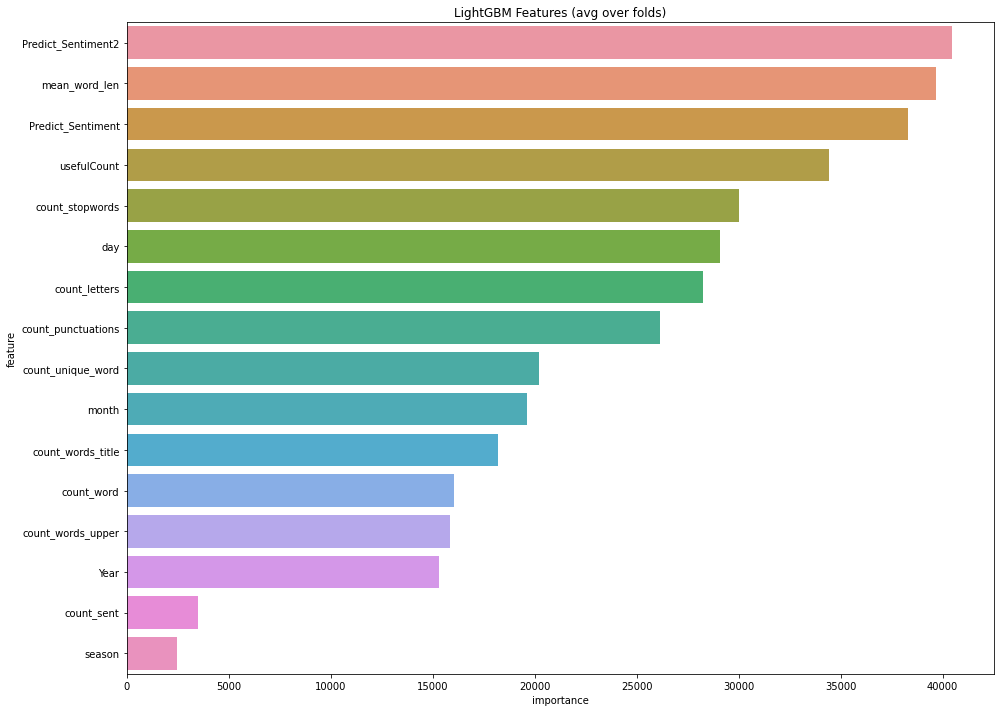

In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending = False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data = best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

##Logistic Regression

In [ ]:
lr_tfidf = LogisticRegression(C=0.00007, max_iter=200)
lr_tfidf.fit(df_train_features, df_train['Review_Sentiment'])

LogisticRegression(C=7e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_pred_tfidf = lr_tfidf.predict(df_test_features)

acc_lr = accuracy_score(df_test['Review_Sentiment'],lr_pred_tfidf)
print(acc_lr)
lr_cm = confusion_matrix(df_test['Review_Sentiment'], lr_pred_tfidf)

0.6624220108417715


In [ ]:
lr_pred_tfidf=pd.DataFrame(lr_pred_tfidf)
prediction_lr = lr_pred_tfidf.to_csv('prediction_lr.csv')

# Applying DL Models

##Neural Network 1

In [ ]:
import keras 
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# making our dependent variable
solution = y_test.copy()

# Model Structure
model = Sequential()
model.add(Input(shape=(df_train_features.shape[1],)))
model.add(Dense(300))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'sigmoid'))

#  Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# inputs = Input(shape=(df_train_features.shape[1],), sparse=True)
# L1 = (Dense(200))(inputs)
# L1_N = (BatchNormalization())(L1)
# L1_Act = (Activation('relu'))(L1_N)
# L1_Drop = (Dropout(0.5))(L1_Act)
# L2 = (Dense(200))(L1_Drop)
# L2_N = (BatchNormalization())(L2)
# L2_Act = (Activation('relu'))(L2_N)
# L2_Drop = Dropout(0.5)(L2_Act)
# L3 = (Dense(100, activation = 'relu'))(L2_Drop)
# outputs = (Dense(1, activation = 'sigmoid'))(L3)
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 300)               1500300   
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
activation_4 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 400)               120400    
_________________________________________________________________
activation_5 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 400)              

In [ ]:
print(df_train_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
df_train['review_clean']

0         year old year old son husband tri get pregnant...
1         junel fe work accord need lighter manag period...
2         made psychot episod made gain weight super moo...
3         bad cystic acn sinc middl school dermo put acc...
4                                 tri everyth botox miracul
                                ...                        
117319    year hard drink woke yesterday throw death han...
117320    th month take far birth control aspect great u...
117321    medic work month start episod atrial fibril do...
117322    lexapro year work great troubl find good medic...
117323    given drug tenni elbow although help pain smal...
Name: review_clean, Length: 117324, dtype: object

Epoch 1/10
1485/1485 [==============================] - 10s 6ms/step - loss: 0.2161 - accuracy: 0.8661 - val_loss: 0.2992 - val_accuracy: 0.8259
Epoch 2/10
1485/1485 [==============================] - 10s 7ms/step - loss: 0.1841 - accuracy: 0.8880 - val_loss: 0.3065 - val_accuracy: 0.8328
Epoch 3/10
1485/1485 [==============================] - 10s 7ms/step - loss: 0.1620 - accuracy: 0.9020 - val_loss: 0.3141 - val_accuracy: 0.8348
Epoch 4/10
1485/1485 [==============================] - 10s 7ms/step - loss: 0.1434 - accuracy: 0.9148 - val_loss: 0.3245 - val_accuracy: 0.8416
Epoch 5/10
1485/1485 [==============================] - 11s 7ms/step - loss: 0.1275 - accuracy: 0.9240 - val_loss: 0.3181 - val_accuracy: 0.8415
Epoch 6/10
1485/1485 [==============================] - 10s 7ms/step - loss: 0.1160 - accuracy: 0.9328 - val_loss: 0.3582 - val_accuracy: 0.8423
Epoch 7/10
1485/1485 [==============================] - 10s 7ms/step - loss: 0.1110 - accuracy: 0.9348 - val_loss: 0.3482 - val_ac

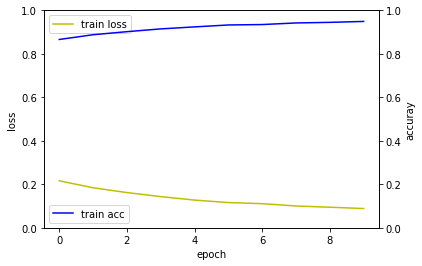

In [ ]:
# 4. Train model
hist = model.fit(df_train_features, y_train, epochs=10, batch_size=64, validation_data=(df_val_features, y_val))

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
y_pred_DL1 = model.predict(df_test_features.toarray())

In [ ]:
y_pred_DL1 = y_pred_DL1>0.5

In [ ]:
acc_DL1 = accuracy_score(y_test, y_pred_DL1)
print(acc_DL1)

0.6384882888411578


In [ ]:
y_pred_DL1=pd.DataFrame(y_pred_DL1)
y_pred_DL1=y_pred_DL1.idxmax(axis=1)
prediction_DL1 = y_pred_DL1.to_csv('prediction_DL1.csv')

##Neural Network 2

In [ ]:
df_tr, df_val, y_tr, y_val = train_test_split(df_train['review_clean'].values.astype('U'),y_train, test_size=0.1)

In [ ]:
df_tr.shape

(105591,)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (KerasLayer)           (None, 128)               124642688 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 3075      
Total params: 124,777,859
Trainable params: 135,171
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/50
825/825 [==============================] - 5s 5ms/step - loss: 0.7686 - accuracy: 0.6853 - val_loss: 0.7143 - val_accuracy: 0.7130
Epoch 2/50
825/825 [==============================] - 4s 5ms/step - loss: 0.7107 - accurac

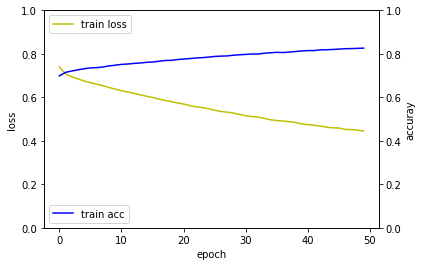

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer

import tensorflow_hub as hub
import tensorflow as tf
from numpy.random import seed
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[50], 
                           input_shape=[], dtype=tf.string, name='input', trainable=False)
np.random.seed(1)
model = Sequential()
model.add(hub_layer)
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation='softmax', name='output'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
hist = model.fit(df_tr, y_tr, epochs=50, batch_size=128,validation_data=(df_val, y_val))

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
y_pred = model.predict(df_test['review_clean'])

In [ ]:
y_pred_DL2 = (y_pred > 0.5) 

In [ ]:
acc_DL2 = accuracy_score(y_test,y_pred_DL2)
print(acc_DL2)

0.7489516211516826


In [ ]:
y_pred_DL2=pd.DataFrame(y_pred_DL2)
y_pred_DL2=y_pred_DL2.idxmax(axis=1)
prediction_DL2 = y_pred_DL2.to_csv('prediction_DL2.csv')

##LSTM

In [ ]:
import tensorflow as tf
import tensorflow 

#from tensorflow import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

# fix random seed for reproducibility
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 3000
EMBEDDING_DIM = 160
# MAX_NB_WORDS = 500
# max_review_length = 500
# EMBEDDING_DIM = 160
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None)
tokenizer.fit_on_texts(df_train['review_clean'].values.astype('U'))
train_sequences = tokenizer.texts_to_sequences(df_train['review_clean'].values.astype('U'))
test_sequences = tokenizer.texts_to_sequences(df_test['review_clean'])
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)
word_index = tokenizer.word_index
print(len(tokenizer.word_index))

28639


In [ ]:
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = MAX_SEQUENCE_LENGTH

model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(50))
#model.add(Attention(MAX_SEQUENCE_LENGTH))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# nb_words  = min(MAX_NB_WORDS, len(word_index))
# lstm_out = max_review_length

# model = Sequential()
# model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=max_review_length))
# #model.add(Dropout(0.2))

# ## add conv using kernal No.32 and size 3x3, actiation='relu'(rm neg)
# # model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# # model.add(MaxPool1D(pool_size=2))
# model.add(Bidirectional(LSTM(40, return_sequences=True)))
# #model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(40)))
# #model.add(Bidirectional(LSTM(20)))
# #model.add(Attention(max_review_length))
# model.add(Dense(3, activation = 'softmax'))

# ## one-code mutiple categories targets use 'categorical_crossentropy' not 'binary_crossentropy'
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics =['accuracy'])

In [ ]:
# Split Training & Validation Data
from sklearn.model_selection import train_test_split


print('creating train and validation data by dividing train_data in 80:20 ratio')
######################################################

X_train_t, X_train_val, Y_train_t, y_train_val = train_test_split(X_train, y_train, test_size = 0.15)

######################################################
print('train data shape:', X_train_t.shape)
print('validation data shape:', X_train_val.shape)
print('Data is ready for training!!')

creating train and validation data by dividing train_data in 80:20 ratio
train data shape: (99725, 100)
validation data shape: (17599, 100)
Data is ready for training!!


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Run LSTM Model
batch = 32 
epoch = 30

## set name for the mdoel
training_cycle = 1
notebookname = "Drug_Data_"
variant = "LSTM_w_stopwords_"
version = "1.0_"
title = notebookname + variant + version

stamp = '{}training_cycle{}batchsize_{}'.format(title,training_cycle,batch)
print(stamp)

## save the best model
best_model_path = title + stamp + 'best.h5'
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only = True) ## save only best model

## if 4 steps without decreasing of loss in valid set, stop the trainning
early_stopping = EarlyStopping(patience = 4)

LSTM_model = model.fit(X_train_t, Y_train_t, batch_size=batch, epochs=epoch,
                       validation_data=(X_train_val, y_train_val),callbacks=[model_checkpoint], shuffle = True)

best_score = min(LSTM_model.history['val_loss'])

Drug_Data_LSTM_w_stopwords_1.0_training_cycle1batchsize_32
Epoch 1/30
3117/3117 [==============================] - 92s 19ms/step - loss: 0.4030 - accuracy: 0.7370 - val_loss: 0.3328 - val_accuracy: 0.7915
Epoch 2/30
3117/3117 [==============================] - 71s 23ms/step - loss: 0.3060 - accuracy: 0.8057 - val_loss: 0.3150 - val_accuracy: 0.8015
Epoch 3/30
3117/3117 [==============================] - 74s 24ms/step - loss: 0.2753 - accuracy: 0.8243 - val_loss: 0.3091 - val_accuracy: 0.8079
Epoch 4/30
3117/3117 [==============================] - 75s 24ms/step - loss: 0.2452 - accuracy: 0.8446 - val_loss: 0.3044 - val_accuracy: 0.8115
Epoch 5/30
3117/3117 [==============================] - 73s 23ms/step - loss: 0.2196 - accuracy: 0.8622 - val_loss: 0.3074 - val_accuracy: 0.8154
Epoch 6/30
3117/3117 [==============================] - 60s 19ms/step - loss: 0.1902 - accuracy: 0.8823 - val_loss: 0.3190 - val_accuracy: 0.8139
Epoch 7/30
3117/3117 [==============================] - 69s 22ms/

In [ ]:
y_pred_lstm = model.predict(X_test)

In [ ]:
y_pred_lstm = (y_pred_lstm > 0.5) 

In [ ]:
acc_lstm = accuracy_score(y_test,y_pred_lstm)
print(acc_lstm)

0.8362739081517848


In [ ]:
y_pred_lstm=pd.DataFrame(y_pred_lstm)
y_pred_lstm=y_pred_lstm.idxmax(axis=1)
prediction_lstm = y_pred_lstm.to_csv('prediction_lstm.csv')

##CNN

In [ ]:
import random
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_train['review_clean'].values.astype('U'))
train_X = tokenizer.texts_to_sequences(df_train['review_clean'].values.astype('U'))
test_X = tokenizer.texts_to_sequences(df_test['review_clean'].values.astype('U'))

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = 3
        self.embedding = nn.Embedding(max_features, embed_size)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [ ]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(df_train['Review_Sentiment'], dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(df_test['Review_Sentiment'], dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),3))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==df_test['Review_Sentiment'])/len(df_test['Review_Sentiment'])
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/6 	 loss=334.0802 	 val_loss=285.3534  	 val_acc=0.7850  	 time=100.49s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 2/6 	 loss=274.3927 	 val_loss=265.4134  	 val_acc=0.8005  	 time=99.85s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 3/6 	 loss=243.2967 	 val_loss=255.6435  	 val_acc=0.8096  	 time=99.48s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 4/6 	 loss=215.8640 	 val_loss=248.9171  	 val_acc=0.8174  	 time=99.73s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 5/6 	 loss=191.0200 	 val_loss=236.5562  	 val_acc=0.8283  	 time=99.38s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 6/6 	 loss=166.3823 	 val_loss=233.8495  	 val_acc=0.8371  	 time=99.63s


In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')


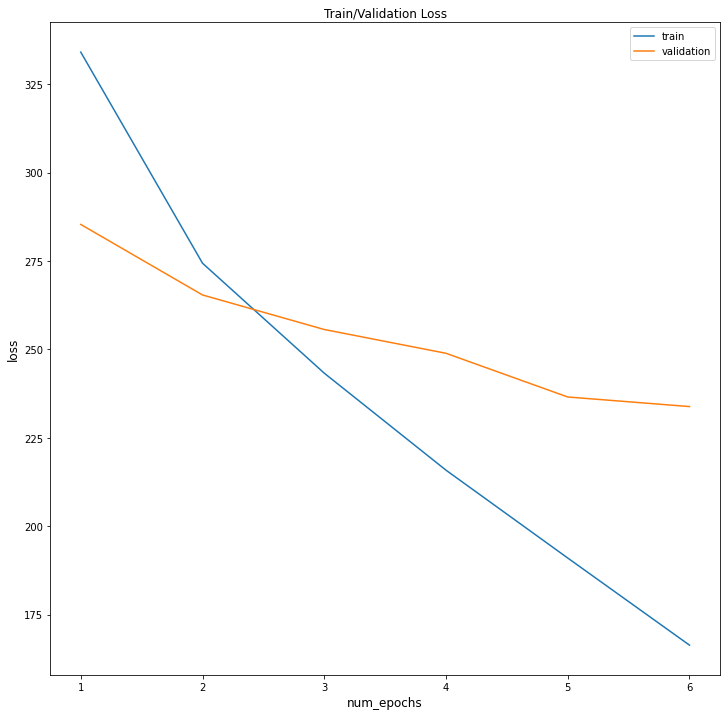

In [ ]:
plot_graph(n_epochs)


In [ ]:
classes = [0,1,2]

In [ ]:
y_pred_cnn = [classes[x] for x in val_preds.argmax(axis=1)]

In [ ]:
y_pred_cnn=pd.DataFrame(y_pred_cnn)
y_pred_cnn=y_pred_cnn.idxmax(axis=1)
prediction_cnn = y_pred_cnn.to_csv('prediction_cnn.csv')

# Harvard emotional dictionary

Emotional analysis using the Harvard emotional dictionary

In [ ]:
harvardDict = pd.read_excel('drive/My Drive/drugsCom_raw/inquirerbasic.xls')
harvardDict

,Entry,Source,Positiv,Negativ
0,A,H4Lvd,NaN,NaN
1,ABANDON,H4Lvd,NaN,Negativ
2,ABANDONMENT,H4,NaN,Negativ
3,ABATE,H4Lvd,NaN,Negativ
4,ABATEMENT,Lvd,NaN,NaN
...,...,...,...,...
11783,ZENITH,H4,Positiv,NaN
11784,ZERO,H4Lvd,NaN,NaN
11785,ZEST,H4,Positiv,NaN
11786,ZINC,H4Lvd,NaN,NaN


In [ ]:
harvardDict["Entry"] = harvardDict["Entry"].astype(str)

Positive words list from the Harvard emotional dictionary

In [ ]:
positiveWords = []
for i in range(0,len(harvardDict.Positiv)):
    if harvardDict.iloc[i,2] == "Positiv":
        temp = harvardDict.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        positiveWords.append(temp2)

positiveWords = list(set(positiveWords))
print("Number of positive words:", len(positiveWords))

Number of positive words: 1637


Negative words list from the Harvard emotional dictionary

In [ ]:
negativeWords = []
for i in range(0,len(harvardDict.Positiv)):
    if (harvardDict.iloc[i,3] == "Negativ"):
        temp = harvardDict.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1)  
        negativeWords.append(temp2)

negativeWords = list(set(negativeWords))
print("Number of negative words:", len(negativeWords))

Number of negative words: 2006


In [ ]:
vectorizer1 = CountVectorizer(vocabulary = positiveWords)
content = df_test['review_clean']
X1 = vectorizer1.fit_transform(content)
f1 = pd.DataFrame(X1.toarray())
f1.columns = positiveWords
df_test["Num Positive Words"] = f1.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = negativeWords)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = pd.DataFrame(X2.toarray())
f2.columns = negativeWords
df_test["Num Negative Words"] = f2.sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
f1

,luck,idolize,hope,distinguish,defend,intimate,nurse,authenticity,regal,reconciliation,warmhearted,veritable,passionate,well,greatness,miracle,kindness,softness,sanctuary,nobility,guardian,dignified,beloved,workmanship,abide,council,discretion,amazement,enlightenment,rescue,appeal,fantasy,agreement,impervious,exult,defender,earnest,alliance,negotiate,opportune,...,visionary,precaution,credentials,captivation,ideal,prominent,angelic,godlike,poignant,resolved,coherent,savings,know,condone,enrich,understood,essential,excellence,heroism,prosperous,diligent,acquaint,obedient,loyal,brotherhood,appreciative,permission,versatile,distinction,empathy,solace,tenderness,excitement,free,clean,mint,arbiter,maximize,handsome,accept
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
f2

,condescending,bogus,sad,misrepresent,nasty,seize,unlucky,exploit,unreliable,adversary,belittle,discriminate,bereft,fugitive,lifeless,debatable,intrude,sever,bloody,deficient,prejudice,nag,imperfect,decrease,drown,hoard,risky,terrible,difficulty,dictate,bore,too,blurt,exaggeration,frantically,ultimatum,assassin,delusion,sentence,equivocal,...,dread,haphazard,miserable,calamity,incessant,venom,bristle,succumb,insignificant,censor,depreciation,avoid,presumptuous,inhibition,growl,distrustful,brood,nullify,worn,competitive,evict,dump,havoc,mangle,snore,strangle,fascist,freak,unaccustomed,clutter,bereavement,mishandle,farce,insinuate,close,drag,disguise,nonsense,manipulation,eccentric
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Deciding the sentiment

In [ ]:
df_test["Positiv Ratio"] = df_test["Num Positive Words"]/(df_test["Num Positive Words"]+df_test["Num Negative Words"])
df_test["Sentiment Harvard list"] = df_test["Positiv Ratio"].apply(lambda x: 2 if (x>=0.5) else (0 if (x<0.5) else 1))
df_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,uniqueID,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,Year,month,day,review_clean,Num Positive Words,Num Negative Words,Positiv Ratio,Sentiment Harvard list
86219,175069,Xylometazoline,Nasal Congestion,"""Probably the only easily accessible sympathom...",10,2015-11-02,0,2.0,2015,11,2,probabl easili access sympathomimet wide avail...,NaN,NaN,NaN,1
133501,92287,Lyrica,Neuralgia,"""Makes me feel very sleepy and spaced out but ...",7,2009-08-25,38,2.0,2009,8,25,make feel sleepi space realli help pain also i...,NaN,NaN,NaN,1
51045,164714,Librax,Irritable Bowel Syndrome,"""I started taking librax for my ibs about 4 da...",9,2015-08-18,40,2.0,2015,8,18,start take librax ib day ago pain almost gone ...,NaN,NaN,NaN,1
4447,59512,Avelox,Sinusitis,"""The only problem I have with this medication ...",8,2011-02-25,9,2.0,2011,2,25,problem medic far expens far side effect light...,2.0,12.0,0.142857,0
150628,220893,Loestrin 24 Fe,Birth Control,"""I started taking this pill on a Sunday, by Tu...",3,2009-10-04,4,0.0,2009,10,4,start take pill sunday tuesday bleed heavili c...,NaN,NaN,NaN,1


In [ ]:
df_test.shape

(39108, 16)

#Voting

In [ ]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data, grouped, on='condition', how='left')
    return data

df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [ ]:
all_preds= pd.read_csv('/content/final_collected_preds.csv')
print(all_preds.columns)
dict_all_models_pred =[all_preds['NB'],all_preds['LR'],all_preds['DL1'],all_preds['DL2'],all_preds['LSTM']]


In [ ]:
#order:  NB,Lr,LGBM,DL1, DL2, LSTM,Harvard
def voting():
  ML_acc_list = [0.57949,0.663]
  DL_acc_list = [0.6370,0.7449,0.84]
  final=[0] * 39108
  total=[0] * 39108
  i=0

  for i in range(len(ML_acc_list)):
    inter = (ML_acc_list[i]/sum(ML_acc_list))*dict_all_models_pred[i]
    final = [sum(x) for x in zip(inter, final)]
    i=i+1
    
  final_nn=[0] * 39108
  for i in range(len(DL_acc_list)):
    inter_nn = (DL_acc_list[i]/sum(DL_acc_list))*dict_all_models_pred[i]
    final_nn = [x + y for x, y in zip(inter_nn, final_nn)]
    i=i+1

  total = [sum(x) for x in zip(final, final_nn,all_preds['LGBM'],all_preds['Sentiment Harvard list'])]
  
  total = total*df_test['usefulCount']
  return total 

In [ ]:
arr = voting()
df_test['total_pred']= arr
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})
df_test=df_test.reset_index()
df_test

In [ ]:
df_test.columns = df_test.columns.map('_'.join)
df_test = df_test.reset_index()
df_test.columns

In [ ]:
df_test=df_test.sort_values(['condition_','total_pred_mean'],ascending=False).groupby('condition_').head(6)
df_test

In [ ]:
df_test.to_csv('final_prediction_values.csv')